In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl

# Visualize the Data

In [3]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Return,Open-Close,Open-Low,Open-High,Close-MA 20D,RSI 14D,Normalized Volume,Realized Volatility 30D,VIX,VIX Move,VIX Open-Close
0,1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,0.007283,0.532690,-0.556965,0.100032,14.25,0.079545,0.011356
1,1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.009975,0.563792,0.273094,0.099786,13.53,-0.050526,-0.024513
2,1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.008364,0.554631,0.115542,0.097703,13.50,-0.002217,-0.014599
3,1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.008066,0.561685,0.143239,0.081286,13.13,-0.027407,-0.039503
4,1995-01-09,0.000326,0.000347,-0.002019,0.002388,0.006700,0.564956,-0.229424,0.081226,13.33,0.015232,-0.014782


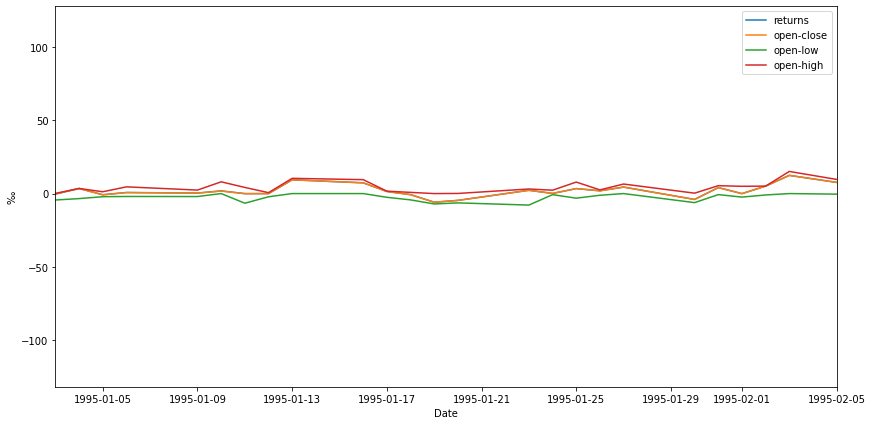

In [4]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Return']*1000, label = 'returns')
ax.plot(df['Date'], df['Open-Close']*1000, label = 'open-close')
ax.plot(df['Date'], df['Open-Low']*1000, label = 'open-low')
ax.plot(df['Date'], df['Open-High']*1000, label = 'open-high')

ax.set_xlabel('Date')
ax.set_ylabel('‰')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('1995-02-05'))
plt.legend()
plt.show()

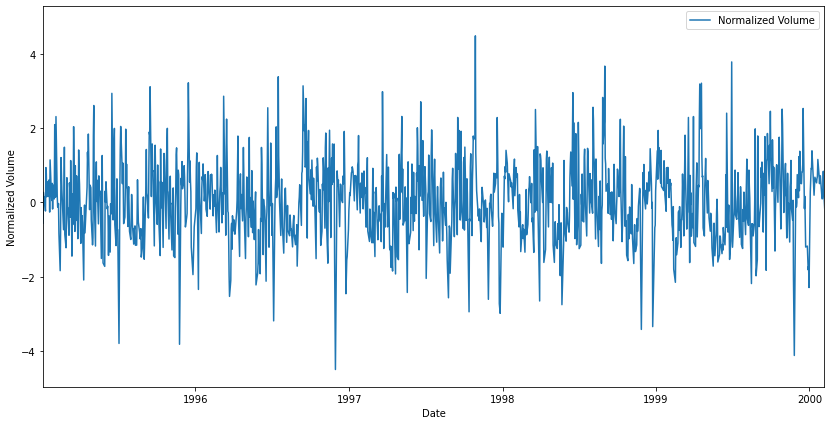

In [5]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Normalized Volume'], label = 'Normalized Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Volume')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('2000-02-05'))
plt.legend()
plt.show()

# Single layer MLP GAN

In [6]:
def prep_data(data: np.array, window_len, scaler) -> np.array:
    
    """
    Args:
      -  data = np.array
      -  window_len = length of window
      -  scaler = sklearn.preprocessing

    Returns:
      - processed: preprocessed data as python list
    """
    # normalize data
    scaler = scaler.fit(data)
    scaled_data = scaler.transform(data)
    
    # group data into windows of length window_len
    windows = []
    for i in range(len(data) - window_len):
        windows.append(scaled_data[i:i+window_len])
        
    # reorder the data
    idx = np.random.permutation(len(windows))

    processed = []
    for i in range(len(windows)):
        processed.append(windows[idx[i]])
    
    return processed


Very simple GAN implementation for our baseline. Will use convolutions and TimeGAN as the next models

In [7]:
class Generator(torch.nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()
        self.input_length = input_length

    def forward(self, x):
        return self.activation(self.dense_layer(x))
    
    def dim(self):
        return self.input_length

NameError: name 'torch' is not defined

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [556]:
def train_gan(true_data, training_steps, generator, discriminator,lr = 0.001):

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr = lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    # binary cross entropy loss
    loss = nn.BCELoss()
    true_data = torch.tensor(true_data).float()
    true_labels = torch.tensor(np.ones((len(true_data),1))).float()
    for i in range(training_steps):
        
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # if minmaxscaling was used, the inputs should be bertween 0 and 1
        noise = torch.rand(true_data.shape[0], true_data.shape[1])
        
        # generator
        generated_data = generator(noise)
       
        generator_discriminator_out = discriminator(generated_data)
        
       # print(generator_discriminator_out.shape, true_labels.shape)
        
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        
        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)        
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros((len(true_data),1)))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
       
        discriminator_optimizer.step()
        if i%30==0:
           
            print("epoch: ", i, "discriminator loss: ",  discriminator_loss.item())
    return generator, discriminator
        

In [595]:
# define minmax scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
df = df.drop(['Close-MA 20D', 'RSI 14D','Realized Volatility 30D','VIX Move'], axis=1)
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)
data = np.array(data)
reshaped_data =  data.reshape(len(data),data.shape[1]*data.shape[2])

print(data.shape)

6769 (30, 7)
(6769, 30, 7)


In [596]:
## x5 here to increase dimensionality, see if it helps
generator = Generator(reshaped_data.shape[1])
discriminator = Discriminator(reshaped_data.shape[1])
gen, disc = train_gan(reshaped_data, 300, generator, discriminator,0.005)

epoch:  0 discriminator loss:  0.7651028633117676
epoch:  30 discriminator loss:  0.4338780641555786
epoch:  60 discriminator loss:  0.40233466029167175
epoch:  90 discriminator loss:  0.6825727224349976
epoch:  120 discriminator loss:  0.7305316925048828
epoch:  150 discriminator loss:  0.7301138639450073
epoch:  180 discriminator loss:  0.6394908428192139
epoch:  210 discriminator loss:  0.5284666419029236
epoch:  240 discriminator loss:  0.4142296314239502
epoch:  270 discriminator loss:  0.3189925253391266


In [545]:
noise = torch.rand(reshaped_data.shape[0], reshaped_data.shape[1])
generated_data = gen(noise)
generated_data = generated_data.reshape(data.shape[0],data.shape[1],data.shape[2])
generated_data = generated_data.detach().numpy()

In [546]:
generated_data.shape

(6769, 30, 7)

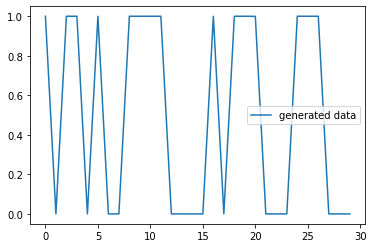

In [547]:
plt.plot(generated_data[0,:,0],label='generated data')
noise_0 = noise[0].reshape(30,7)[:,0]
#plt.plot(noise_0,label = 'noise')
plt.legend()
plt.show()

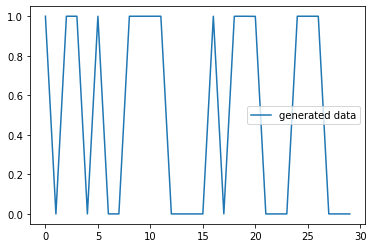

In [548]:
plt.plot(generated_data[1,:,0],label='generated data')
noise_1 = noise[0].reshape(30,7)[:,1]
#plt.plot(noise_1,label = 'noise')
plt.legend()
plt.show()

For some reason it learns the same time series for al 6000+ points and is always 0 or 1. Go figure. Tried removing the sigmoid layer from the generator, and it produced complete garbage.

In [562]:
class Generator2(torch.nn.Module):

    def __init__(self, input_length: int):
        super(Generator2, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_length,500),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(500,1200),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(1200,800),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(800,input_length)
                                    )
    def forward(self, x):
        return self.net(x)

In [563]:
class Discriminator2(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator2, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_length,500),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(500,400),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(400,400),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(400,1),
                                 nn.Sigmoid()
                                    )
    def forward(self, x):
        return self.net(x)

In [598]:
generator2 = Generator2(reshaped_data.shape[1])
discriminator2 = Discriminator2(reshaped_data.shape[1])
gen2, disc2 = train_gan(reshaped_data, 200, generator2, discriminator2,0.0005)

epoch:  0 discriminator loss:  0.6794744729995728
epoch:  30 discriminator loss:  0.22435890138149261
epoch:  60 discriminator loss:  0.02730495296418667
epoch:  90 discriminator loss:  0.10113400220870972
epoch:  120 discriminator loss:  4.05786657333374
epoch:  150 discriminator loss:  0.18482422828674316
epoch:  180 discriminator loss:  0.7161022424697876


The learning rate was too high i think

In [599]:
noise = torch.rand(reshaped_data.shape[0], reshaped_data.shape[1])
generated_data2 = gen2(noise)
generated_data2 = generated_data2.reshape(data.shape[0],data.shape[1],data.shape[2])
generated_data2 = generated_data2.detach().numpy()

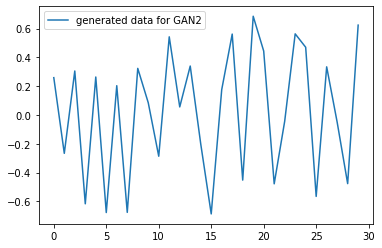

In [600]:
plt.plot(generated_data2[0,:,0],label='generated data for GAN2')
plt.legend()
plt.show()

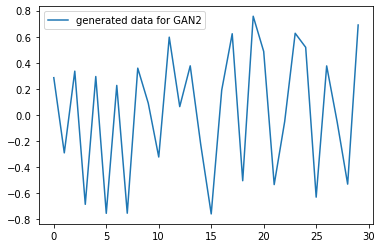

In [601]:
plt.plot(generated_data2[1000,:,0],label='generated data for GAN2')
plt.legend()
plt.show()

There is still the problem, that if you generate 1000 examples, they are always the same

# TimeGAN

In [336]:
# define minmax scaler
scaler = MinMaxScaler()

# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)

6769 (30, 7)


In [337]:
seq_len = 30        # Timesteps
n_seq = 11          # Features

hidden_dim = 24     # Hidden units for generator (GRU & LSTM)

gamma = 1           # discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128

learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]

In [522]:
# Run this on non M1 chip

"""
from ydata_synthetic.synthesizers.timeseries import TimeGAN
# define model
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(data, train_steps=500)
synth.save('synth.pkl')

synth_data = synth.sample(len(data))
"""

"\nfrom ydata_synthetic.synthesizers.timeseries import TimeGAN\n# define model\nsynth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)\nsynth.train(data, train_steps=500)\nsynth.save('synth.pkl')\n\nsynth_data = synth.sample(len(data))\n"

In [ ]:
"""
synth_data = np.array(synth_data)
import pickle as pkl
with open('generated.pkl','wb') as f:
    pkl.dump(synth_data, f)
"""

In [8]:
with open('generated.pkl', 'rb') as f:
    synth_data_time = pkl.load(f)

# Analyzing Results

In [9]:
# define minmax scaler
scaler = MinMaxScaler()
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
df = df.drop(['Close-MA 20D', 'RSI 14D','Realized Volatility 30D','VIX Move'], axis=1)
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)
data = np.array(data)
reshaped_data =  data.reshape(len(data),data.shape[1]*data.shape[2])

print(data.shape)

6769 (30, 7)
(6769, 30, 7)


In [10]:
df.head()

,Return,Open-Close,Open-Low,Open-High,Normalized Volume,VIX,VIX Open-Close
Date,,,,,,,
1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,-0.556965,14.25,0.011356
1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.273094,13.53,-0.024513
1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.115542,13.50,-0.014599
1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.143239,13.13,-0.039503
1995-01-09,0.000326,0.000347,-0.002019,0.002388,-0.229424,13.33,-0.014782


## Visualizing synthetic data for GAN

NameError: name 'generated_data' is not defined

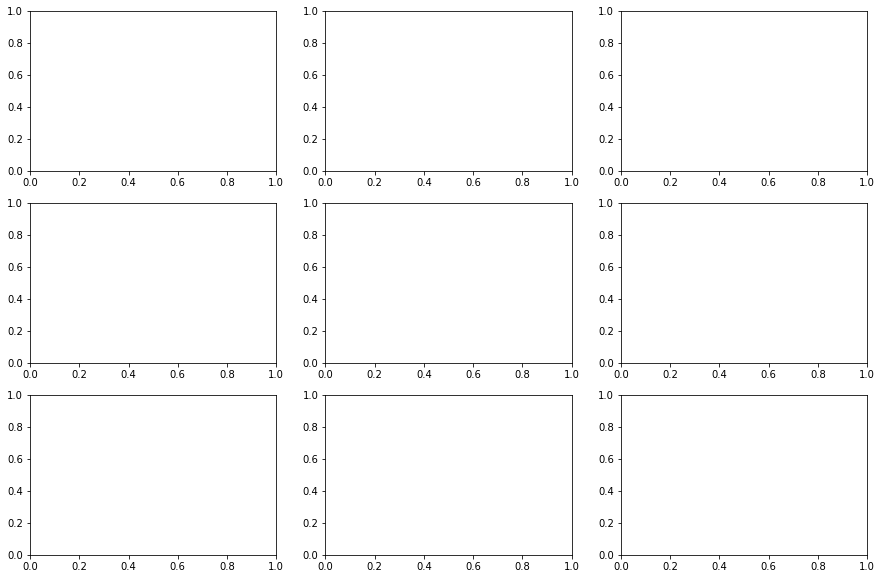

In [11]:
cols = [
    "Return","Open-Close",'Open-Low',"Open-High","Normalized Volume", "VIX", "VIX Open-close"
]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,30))
obs = np.random.randint(len(generated_data.shape))
for j, col in enumerate(cols):
    frame = pd.DataFrame({'Real': data[obs][:, j],
                   'Synthetic': generated_data[obs][:, j]})
    frame.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

## PCA for GAN

In [16]:
from sklearn.decomposition import PCA

In [355]:
seq_len = 30
sample_size = 100
# get random indexes
idx = np.random.permutation(len(data))[:sample_size]
real_sample = data[idx]
synthetic_sample = generated_data[idx]

# reshape
real_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = synthetic_sample.reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)

pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))



NameError: name 'pca_real' is not defined

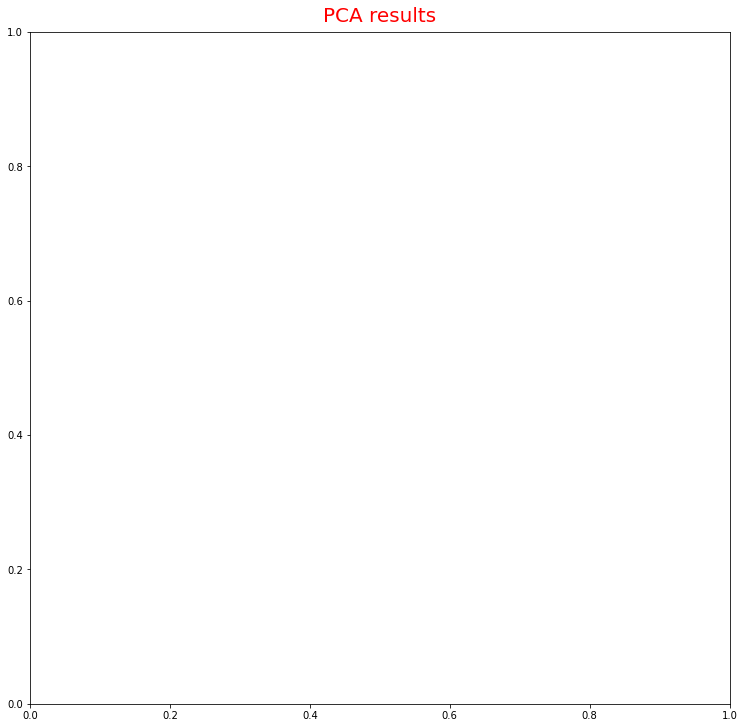

In [15]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')


ax.legend()

## TNSE for GAN

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=n_components, n_iter=300)

tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax2 = fig.add_subplot(spec[0,0])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:700, 0].values, tsne_results.iloc[:700, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[700:, 0], tsne_results.iloc[700:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

NameError: name 'data_reduced' is not defined

## Visualizing synthetic data for GAN2

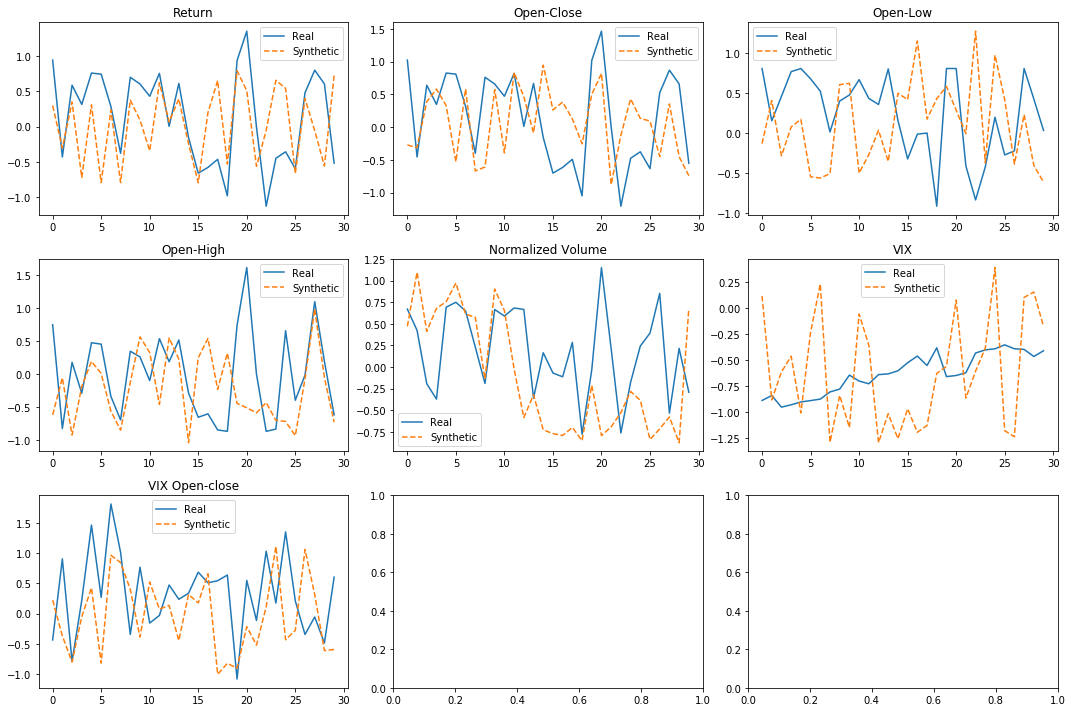

In [602]:
cols = [
    "Return","Open-Close",'Open-Low',"Open-High","Normalized Volume", "VIX", "VIX Open-close"
]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,30))
obs = np.random.randint(len(generated_data2.shape))
for j, col in enumerate(cols):
    frame = pd.DataFrame({'Real': data[obs][:, j],
                   'Synthetic': generated_data2[obs][:, j]})
    frame.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

## PCA for GAN2

In [603]:
seq_len = 30
sample_size = 100
# get random indexes
idx = np.random.permutation(len(data))[:sample_size]
real_sample = data[idx]
synthetic_sample = generated_data2[idx]

# reshape
real_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = synthetic_sample.reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)

pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)

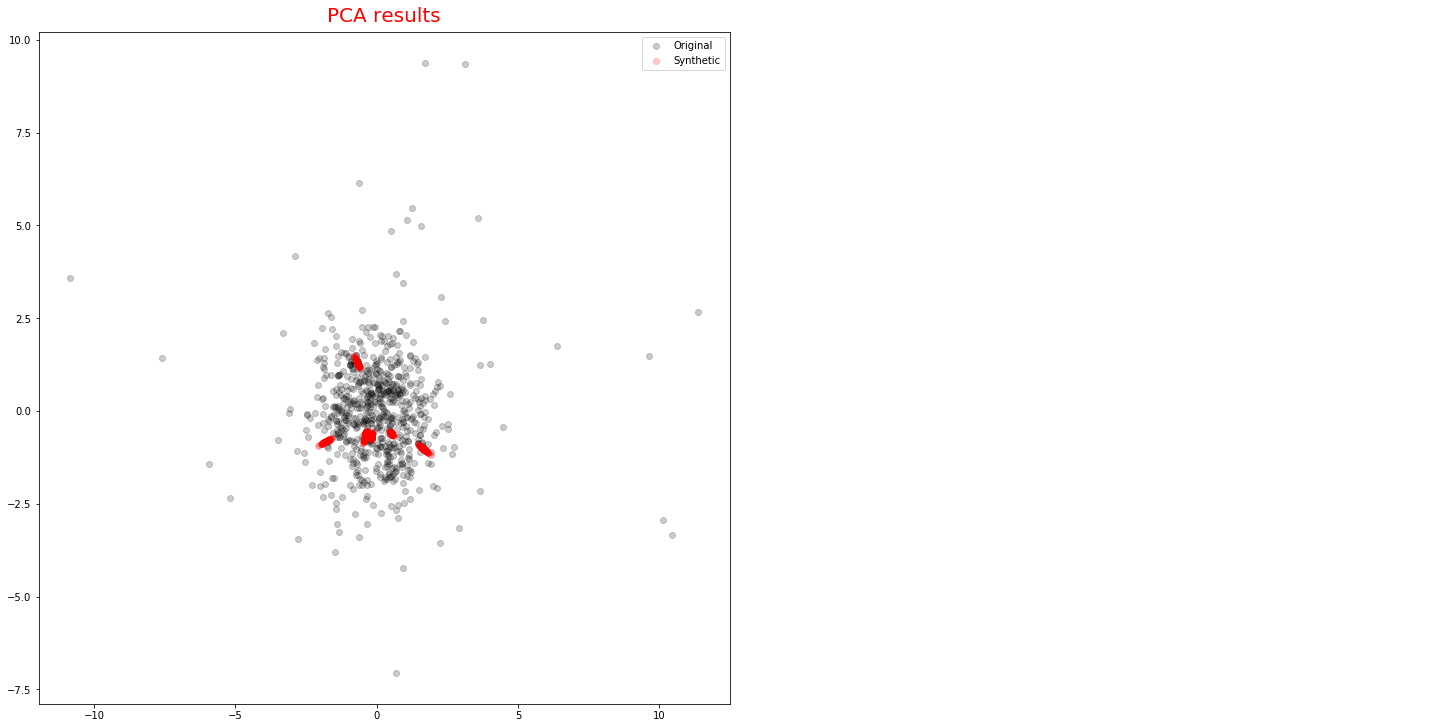

In [604]:

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')


ax.legend()

Better, but still what's happening is that if i generate 6000 samples, they are all exactly the same, which is why the pca is a single point. At least this time the points are neared to the true distribution

## TNSE for GAN2

/opt/anaconda3/envs/finance4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/anaconda3/envs/finance4/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


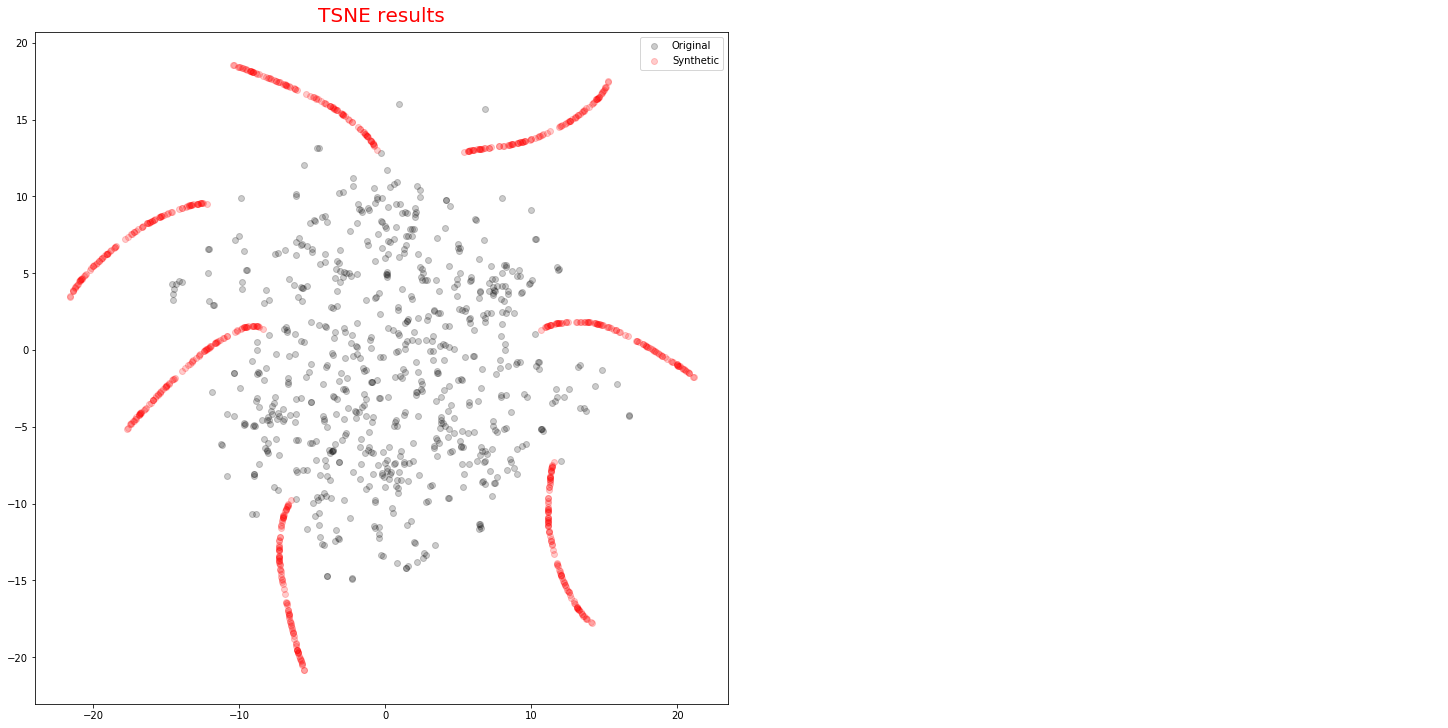

In [605]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=n_components, n_iter=300)

tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax2 = fig.add_subplot(spec[0,0])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:700, 0].values, tsne_results.iloc[:700, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[700:, 0], tsne_results.iloc[700:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

## Visualizing synthetic data for timeGAN

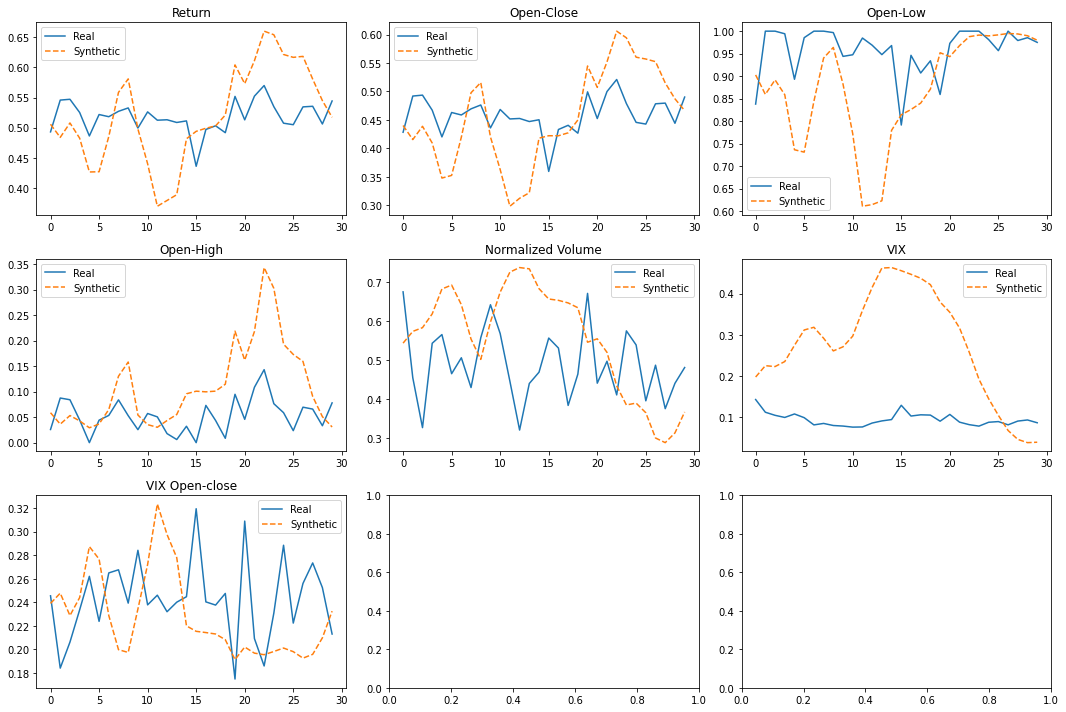

In [12]:
cols = [
    "Return","Open-Close",'Open-Low',"Open-High","Normalized Volume", "VIX", "VIX Open-close"
]

# Plotting some generated samples. Both Synthetic and Original data are still standardized with values between [0, 1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,30))
obs = np.random.randint(len(synth_data_time.shape))
for j, col in enumerate(cols):
    frame = pd.DataFrame({'Real': data[obs][:, j],
                   'Synthetic': synth_data_time[obs][:, j]})
    frame.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

## PCA for TimeGAN

In [17]:
seq_len = 30
sample_size = 100
# get random indexes
idx = np.random.permutation(len(data))[:sample_size]
real_sample = data[idx]
synthetic_sample = synth_data_time[idx]

# reshape
real_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = synthetic_sample.reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)

pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)

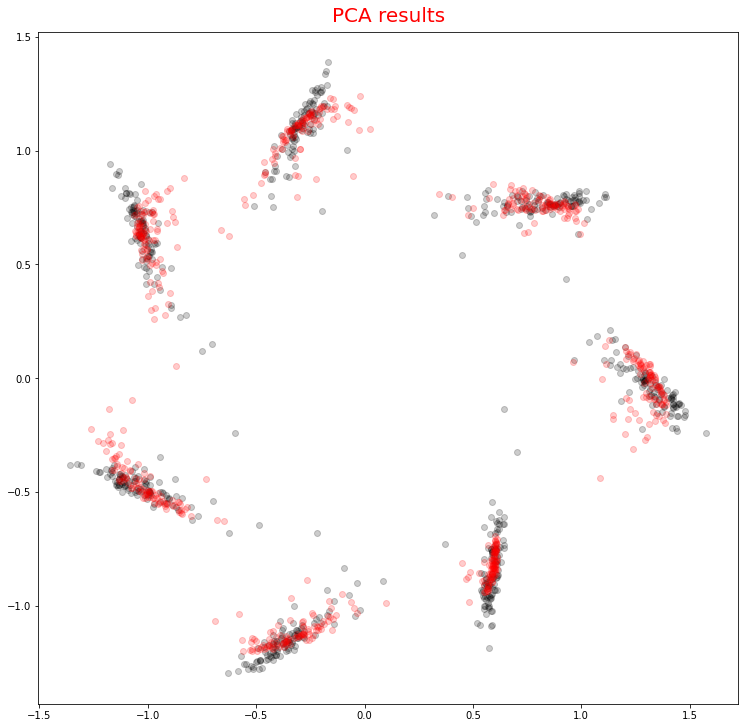

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')

plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')



## TNSE for TimeGAN

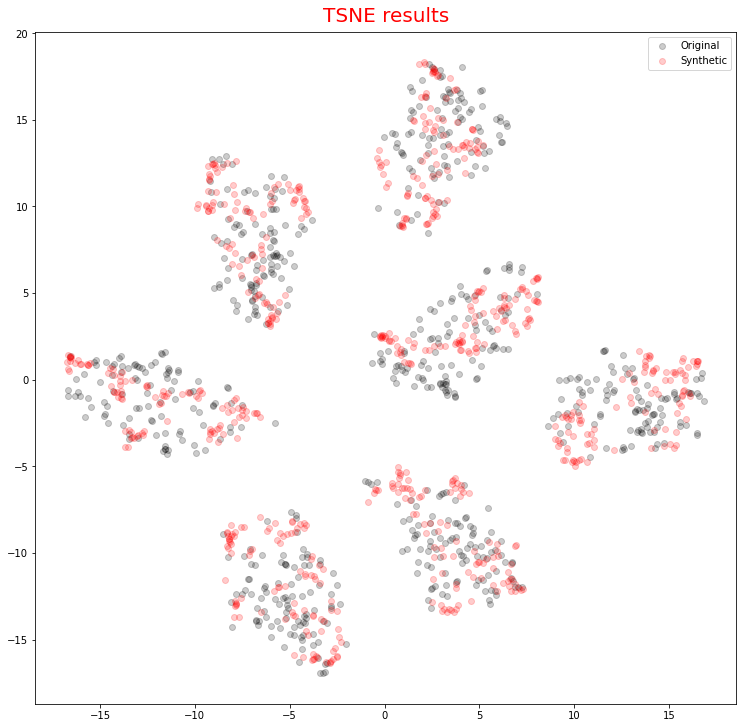

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=n_components, n_iter=300)

tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax2 = fig.add_subplot(spec[0,0])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

# t-SNE scatter plot
plt.scatter(tsne_results.iloc[:700, 0].values, tsne_results.iloc[:700, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[700:, 0], tsne_results.iloc[700:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

# LSTM Prediction

Eventually, we might want to preprocess the data (detrend and such). For now, I am implementing a a simple binary forecasting method. I plotted the data above and I don't see much of a trend in the data, since we model returns anyway, but it might be best practice to subtract the running mean or perform similar kind of preprocessing/feature transformation. Also, I'm going to add code to do proper cross validation for time series (sliding window approach). For now I have only implemented a basic train/test split, which I think should be fine for the midterm report. The main focus should be on the data generation, not the forecasting. also only using return to predict the next day's returns for now, i tried with all features, and it wasn't any better.

In [256]:
def train_test_window(data, window_len, split):    
    """
    Passes sliding window of window_len, and splits into train/test
    
    Args:
      -  data = np.array
      -  window_len = length of window
      -  split = training fraction (e.g 0.8)

    """
    # get train size
    train_set_size = int(np.round(split*len(data)))
    
    # sliding window
    windows = []
    for i in range(len(data) - window_len):
        windows.append(data[i:i+window_len])
         
    #get train/test split
    data = np.array(windows)
    train_size = int(np.round(split*len(data)))

    x_train = data[:train_set_size,:-1,:]
    y_train = np.expand_dims(data[:train_set_size,-1,0],1)
    
    x_test = data[train_set_size:,:-1]
    y_test = np.expand_dims(data[train_set_size:,-1,0],1)

    return x_train, y_train, x_test, y_test
    

In [257]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])

try:
    df = df.set_index('Date').sort_index()
except:
    df = df
    
scaler = MinMaxScaler()


returns = df[['Return']]
scaler.fit(returns)
scaled = scaler.transform(returns)
x_train, y_train, x_test, y_test = train_test_window(scaled, 60,0.9)

#scaler.fit(df.values)
#scaled = scaler.transform(df.values)
#x_train, y_train, x_test, y_test = train_test_window(scaled, 60,0.9)

In [258]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6119, 59, 1) (6119, 1) (620, 59, 1) (620, 1)


In [259]:
import torch
import torchvision

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [260]:
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [261]:
input_dim = x_train.shape[2]
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [262]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [263]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.35981231927871704
Epoch  10 MSE:  0.012933561578392982
Epoch  20 MSE:  0.0028946909587830305
Epoch  30 MSE:  0.0024468260817229748
Epoch  40 MSE:  0.0025789246428757906
Epoch  50 MSE:  0.002564266324043274
Epoch  60 MSE:  0.00247938116081059
Epoch  70 MSE:  0.0024443529546260834
Epoch  80 MSE:  0.0024487157352268696
Epoch  90 MSE:  0.0024454917293041945


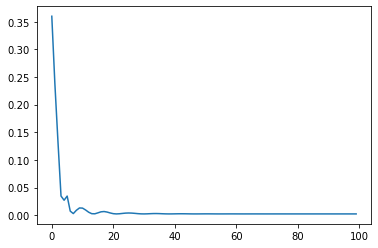

In [264]:
plt.plot(losses)

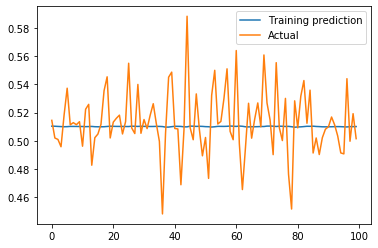

In [265]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [266]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

In [267]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true,pred))

0.5363621506782154


# GRU Prediction

In [268]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [269]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [270]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.2154461145401001
Epoch  10 MSE:  0.00845341943204403
Epoch  20 MSE:  0.0025390349328517914
Epoch  30 MSE:  0.0024578773882240057
Epoch  40 MSE:  0.002458700444549322
Epoch  50 MSE:  0.002477760426700115
Epoch  60 MSE:  0.0024763369001448154
Epoch  70 MSE:  0.0024505197070538998
Epoch  80 MSE:  0.002436700277030468
Epoch  90 MSE:  0.002436272334307432


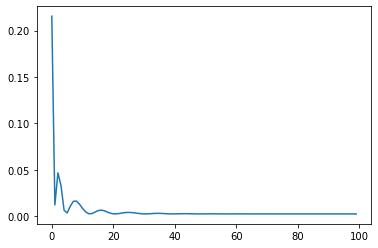

In [271]:
plt.plot(losses)

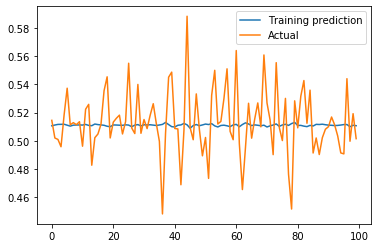

In [272]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [273]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

print(accuracy_score(true,pred))

0.5381598300375878


# Transformer

In [23]:
import torch
from torch.nn import Module, Linear, MSELoss, ModuleList, Conv1d, Dropout, LayerNorm, parameter
import torch.nn.functional as F


In [24]:
def do_attention(query,key,value):
    # get scaled attention scores
    attention_scores = torch.bmm(query, key.transpose(1,2))/torch.sqrt(query.size(-1))
    attention_weights = F.softmax(attention_scores,dim=1)
    return torch.bmm(attention_weights, value)    
   

In [25]:
class AttentionHead(Module):
    
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.Wq = Linear(embed_dim, head_dim)
        self.Wk = Linear(embed_dim, head_dim)
        self.Wv = Linear(embed_dim, head_dim)
    
    def forward(self, h):
        q = self.Wq(h)
        k = self.Wk(h)
        v = self.Wv(h)
        outputs = do_attention(q,k,h)

In [26]:
class MultiHeadAttention(Module):
    
    def __init__(self, hidden_size, num_heads) -> None:
        super().__init__()
        num_heads = num_heads
        # by convention
        head_dim = hidden_size // num_heads
        self.heads = ModuleList(
            [AttentionHead(hidden_size, head_dim) for _ in range(num_heads)]
        )
        self.output = Linear(hidden_size, hidden_size)
        
    def forward(self, h):
        x = torch.cat([head(h) for head in self.heads], dim = 1)
        return self.output(x) 

In [27]:
class FeedForward(Module):
    
    # rule of thumb: hidden size of first layer 4x emebddding dimension
     def __init__(self,hidden_size, intermediate_size, dropout_prob = 0.3) -> None:
        super().__init__()
        # equivalent to dense layer or a position wise feed-forward network
        self.conv1 = Conv1d(in_channels = hidden_size, out_channels = intermediate_size, kernel_size=1)
        self.conv2 = Conv1d(in_channels = intermediate_size, out_channels = hidden_size, kernel_size = 1)
        # standard to use gelu
        self.gelu = F.GELU()
        self.dropout = Dropout(dropout_prob)
    
     def forward(self,x):
        x = self.conv1(x)
        x = self.gelu(x)
        x = self.conv2(x)
        return self.dropout(x)

In [28]:
class TransformerEncoderLayer(Module):
    
    def __init__(self, hidden_size, intermediate_size, num_heads, dropout_prob) -> None:
        super().__init__()
        # layer norm is prefered for transformer
        self.layer_norm1 = LayerNorm(hidden_size)
        self.layer_norm2 = LayerNorm(hidden_size)
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        self.ff = FeedForward(hidden_size, intermediate_size, dropout_prob)
        
    
    def forward(self, x):
        hidden = self.layer_norm1(x)
        #skip connection as in resnet
        x = x + self.attention(hidden)
        x = self.layer_norm2(x)
        # skip connection
        return x + self.ff(x)

In [29]:
class Sine(Module):
    
    def __init__(self,input_size, output_size) -> None:
        
        super().__init__()
        self.out = output_size
        self.weights_linear = parameter.Parameter(torch.randn(input_size, 1))
        self.bias_linear = parameter.Parameter(torch.randn(1))
        self.weights_periodic = parameter.Parameter(torch.randn(in_features, output_size-1))
        self.bias_periodic = parameter.Parameter(torch.randn(output_size-1))
    
    def forward(self, x):
        x = torch.mean(x, axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = torch.expand_dims(time_linear, axis=-1) 
    
        time_periodic = torch.sin(torch.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = torch.expand_dims(time_periodic, axis=-1) 
        return torch.concat([time_linear, time_periodic], axis=-1)
        

In [30]:
class Time2Vec(Module):
    
    def __init__(self, seq_len) -> None:
        super().__init__()
        self.periodic =  Sine(1, seq_len)
        self.linear = Linear(seq_len,2)
        
    def forward(self, x):
        x = self.periodic(x)
        return self.linear(x)

In [31]:
class TransformerEncoder(Module):
    
    def __init__(self, num_hidden, hidden_size, intermediate_size, num_heads, dropout_prob, seq_len) -> None:
        super().__init__()
        self.time_embedding = Time2Vec(seq_len)
        self.layers = ModuleList([TransformerEncoderLayer(hidden_size, intermediate_size, num_heads, dropout_prob)
                                 for _ in range(num_hidden)])
        
    def forward(self, x):
        # get time embedding
        time = self.time_embedding(x)
        # cncatenate it to input
        x = torch.concat([x,time],axis=-1)
        for layer in self.layers:
            x = layer(x)
        return x